In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

import time
import os
import copy


class LeNet5(torch.nn.Module):
    '''
        Define a LeNet with 7 layers
        - Input : 32x32x1
        - Conv1 : 32x32x1  -> 28x28x6
        - Pool1 : 28x28x6  -> 14x14x6
        - Conv2 : 14x14x6  -> 10x10x16
        - Pool2 : 10x10x16 -> 5x5x16
        - Conv3 : 5x5x16   -> 1x1x120
        - FC    : 1x1x120  -> 84
        - FC    : 84       -> 10
    '''
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels = 1, 
                                     out_channels = 6, 
                                     kernel_size = 5, 
                                     stride = 1)
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, 
                                       stride = 2, 
                                       padding = 0)
        
        self.conv2 = torch.nn.Conv2d(in_channels = 6, 
                                     out_channels = 16, 
                                     kernel_size = 5, 
                                     stride = 1)
        
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 2, 
                                       stride = 2, 
                                       padding = 0)
        
        self.conv3 = torch.nn.Conv2d(in_channels = 16, 
                                     out_channels = 120, 
                                     kernel_size = 5, 
                                     stride = 1)

        
        self.fc1 = torch.nn.Linear(1*1*120, 84)

        self.fc2 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
         
        # Flatten CNN output to feed to the fully-connected layer
        x = x.view(-1, 1*1*120)
        
        # Use ReLU activation for first FC layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        
        # Output with 10 classes, use log_softmax
        x = F.log_softmax(self.fc2(x), dim=1)
        return(x)

In [2]:
# Define the transform object to tranform image to tensor and normalize
# (Can also add others for data augmentation)

transform = transforms.Compose([
    transforms.Resize(32),         # Input of LeNet5 is 32x32 grey image
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download the data from MNIST
# Otherwise, to load from disk, use datasets.ImageFolder
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Epoch: 1/10..  Training Loss: 0.168..  Training Acc : 0.946.. Test Loss: 0.066..  Test Accuracy: 0.980
Epoch: 2/10..  Training Loss: 0.059..  Training Acc : 0.982.. Test Loss: 0.042..  Test Accuracy: 0.986
Epoch: 3/10..  Training Loss: 0.044..  Training Acc : 0.986.. Test Loss: 0.043..  Test Accuracy: 0.988
Epoch: 4/10..  Training Loss: 0.037..  Training Acc : 0.989.. Test Loss: 0.045..  Test Accuracy: 0.986
Epoch: 5/10..  Training Loss: 0.030..  Training Acc : 0.991.. Test Loss: 0.054..  Test Accuracy: 0.987
Epoch: 6/10..  Training Loss: 0.029..  Training Acc : 0.991.. Test Loss: 0.044..  Test Accuracy: 0.989
Epoch: 7/10..  Training Loss: 0.026..  Training Acc : 0.992.. Test Loss: 0.042..  Test Accuracy: 0.988
Epoch: 8/10..  Training Loss: 0.023..  Training Acc : 0.993.. Test Loss: 0.040..  Test Accuracy: 0.989
Epoch: 9/10..  Training Loss: 0.022..  Training Acc : 0.994.. Test Loss: 0.053..  Test Accuracy: 0.986
Epoch: 10/10..  Training Loss: 0.021..  Training Acc : 0.994.. Test Loss:

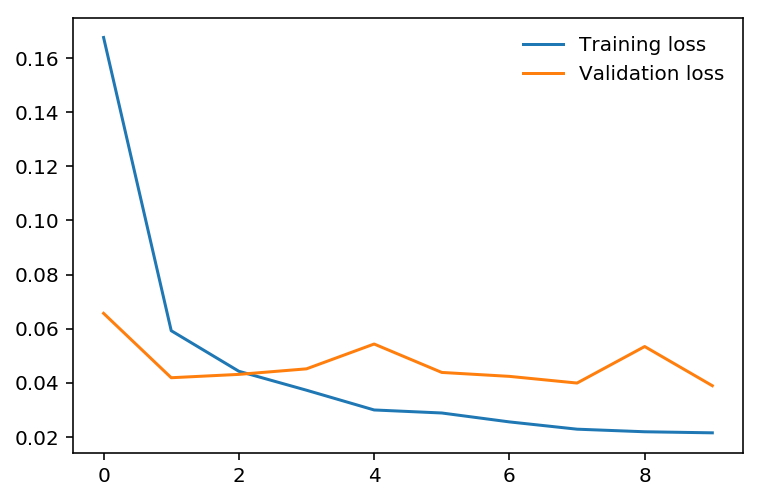

In [3]:
# Define the model, loss and optimizer
model = LeNet5()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


num_of_epochs = 10
train_losses = []
test_losses = []
for e in range(num_of_epochs):
    running_loss = 0
    train_acc = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1) # Get top 1 class
        
        # Count equals and calculate accuracy
        equals = top_class == labels.view(top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
    else:
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation to speed up
        with torch.no_grad():
            for images, labels in testloader:

                # set model to evaluation mode
                # this will turn off the dropout by change the drop_prob to 0
                model.eval()

                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) # Get top 1 class

                # Count equals and calculate accuracy
                equals = top_class == labels.view(top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, num_of_epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Training Acc : {:.3f}..".format(train_acc/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        # set model back to train mode
        # this will turn on the dropout
        model.train()

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Epoch: 1/10..  Training Loss: 0.151..  Training Acc : 0.954.. Test Loss: 0.052..  Test Accuracy: 0.983
Epoch: 2/10..  Training Loss: 0.057..  Training Acc : 0.983.. Test Loss: 0.043..  Test Accuracy: 0.986
Epoch: 3/10..  Training Loss: 0.041..  Training Acc : 0.987.. Test Loss: 0.043..  Test Accuracy: 0.987
Epoch: 4/10..  Training Loss: 0.035..  Training Acc : 0.990.. Test Loss: 0.037..  Test Accuracy: 0.989
Epoch: 5/10..  Training Loss: 0.031..  Training Acc : 0.991.. Test Loss: 0.038..  Test Accuracy: 0.989
Epoch: 6/10..  Training Loss: 0.027..  Training Acc : 0.992.. Test Loss: 0.054..  Test Accuracy: 0.987
Epoch: 7/10..  Training Loss: 0.026..  Training Acc : 0.992.. Test Loss: 0.049..  Test Accuracy: 0.987
Epoch: 8/10..  Training Loss: 0.023..  Training Acc : 0.993.. Test Loss: 0.049..  Test Accuracy: 0.988
Epoch: 9/10..  Training Loss: 0.019..  Training Acc : 0.995.. Test Loss: 0.047..  Test Accuracy: 0.989
Epoch: 10/10..  Training Loss: 0.021..  Training Acc : 0.994.. Test Loss:

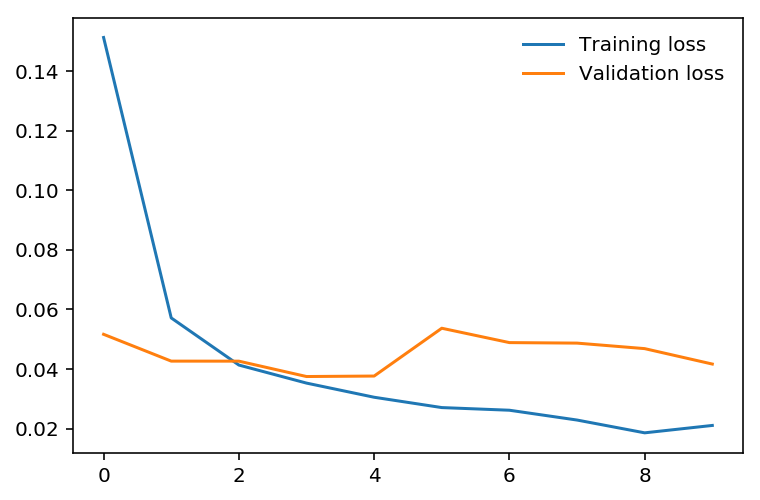

In [4]:
# Define the model, loss and optimizer
model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


num_of_epochs = 10
train_losses = []
test_losses = []
for e in range(num_of_epochs):
    running_loss = 0
    train_acc = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1) # Get top 1 class
        
        # Count equals and calculate accuracy
        equals = top_class == labels.view(top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
    else:
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation to speed up
        with torch.no_grad():
            for images, labels in testloader:

                # set model to evaluation mode
                # this will turn off the dropout by change the drop_prob to 0
                model.eval()

                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) # Get top 1 class

                # Count equals and calculate accuracy
                equals = top_class == labels.view(top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, num_of_epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Training Acc : {:.3f}..".format(train_acc/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        # set model back to train mode
        # this will turn on the dropout
        model.train()

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [9]:
# Define the model, loss and optimizer
model = LeNet5()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


num_of_epochs = 10
train_losses = []
test_losses = []
for e in range(num_of_epochs):
    running_loss = 0
    train_acc = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1) # Get top 1 class
        
        # Count equals and calculate accuracy
        equals = top_class == labels.view(top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
    else:
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation to speed up
        with torch.no_grad():
            for images, labels in testloader:

                # set model to evaluation mode
                # this will turn off the dropout by change the drop_prob to 0
                model.eval()

                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) # Get top 1 class

                # Count equals and calculate accuracy
                equals = top_class == labels.view(top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, num_of_epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Training Acc : {:.3f}..".format(train_acc/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

        # set model back to train mode
        # this will turn on the dropout
        model.train()


Epoch: 1/10..  Training Loss: 0.222..  Training Acc : 0.933.. Test Loss: 0.076..  Test Accuracy: 0.981
Epoch: 2/10..  Training Loss: 0.077..  Training Acc : 0.980.. Test Loss: 0.054..  Test Accuracy: 0.985
Epoch: 3/10..  Training Loss: 0.057..  Training Acc : 0.985.. Test Loss: 0.057..  Test Accuracy: 0.984
Epoch: 4/10..  Training Loss: 0.053..  Training Acc : 0.986.. Test Loss: 0.047..  Test Accuracy: 0.987
Epoch: 5/10..  Training Loss: 0.044..  Training Acc : 0.988.. Test Loss: 0.053..  Test Accuracy: 0.986
Epoch: 6/10..  Training Loss: 0.043..  Training Acc : 0.989.. Test Loss: 0.061..  Test Accuracy: 0.986
Epoch: 7/10..  Training Loss: 0.039..  Training Acc : 0.990.. Test Loss: 0.056..  Test Accuracy: 0.985
Epoch: 8/10..  Training Loss: 0.035..  Training Acc : 0.991.. Test Loss: 0.062..  Test Accuracy: 0.987
Epoch: 9/10..  Training Loss: 0.034..  Training Acc : 0.991.. Test Loss: 0.059..  Test Accuracy: 0.986
Epoch: 10/10..  Training Loss: 0.032..  Training Acc : 0.991.. Test Loss:

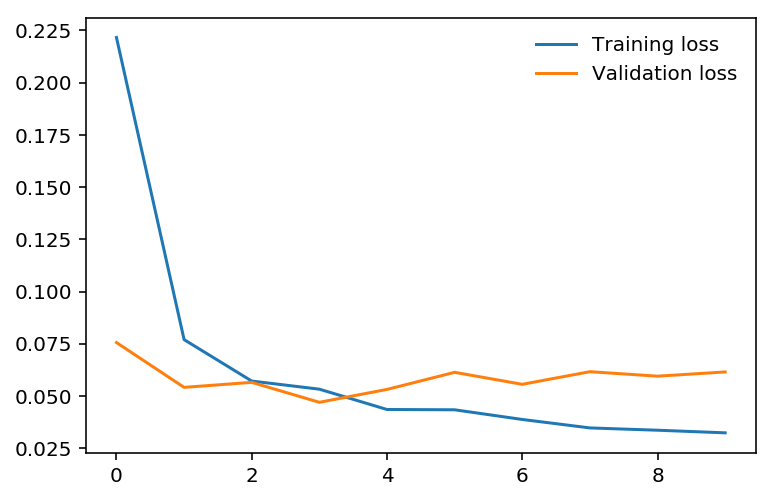

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)